<a href="https://colab.research.google.com/github/oliverob/quantum/blob/master/qgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Generative Adversarial Network (qGAN)

Loading an arbitrary random probability distribution into an n-qubit quantum state normally requires $O(2^n)$ gates which in most algorithms will dominate the complexity of the quantum algorithm and make it useless. By using a qGAN this loading can be done in $O(poly(n))$ gates [[1](https://https://www.nature.com/articles/s41534-019-0223-2)]. 

A qGAN is a quantum version of a [Generative Adversarial Network](https://papers.nips.cc/paper/5423-generative-adversarial-nets) with a quantum generator and a classical discriminator. The quantum generator is trained to transform a given n-qubit input into:
$$
\sum_{j=0}^{2^n-1} \sqrt{p^j_{\theta}}\left| j \right\rangle
$$
where $p^j_{\theta}$ is the probabilty of the state $j$. The discriminator has to try and distinguish between the output of the generator and the training data set. The two networks train alternatively and will eventaully reach a nash equilibrium where the discriminator cannot tell apart the generator and the training set data. The aim of this process is for $p^j_{\theta}$ to approximate the distribution of the training data.

This tutorial will guide you through using a qGAN to load a lognormal distribution to a 2 qubit system.

# Setup

In [1]:
!pip install --upgrade tensorflow==2.1.0  tensorflow-quantum tensorflow-gan tensorflow-probability==0.9 tensorflow-datasets

     |████████████████████████████████| 421.8MB 32kB/s 
     |████████████████████████████████| 3.9MB 46.6MB/s 
     |████████████████████████████████| 368kB 41.4MB/s 
     |████████████████████████████████| 3.2MB 40.3MB/s 
     |████████████████████████████████| 3.4MB 48.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 450kB 37.6MB/s 
     |████████████████████████████████| 3.9MB 44.6MB/s 
     |████████████████████████████████| 5.3MB 37.9MB/s 
     |████████████████████████████████| 163kB 50.9MB/s 
     |████████████████████████████████| 1.4MB 44.8MB/s 
     |████████████████████████████████| 112kB 48.6MB/s 
     |████████████████████████████████| 133kB 48.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=2ad6cbdc07e51d75f24df6a3c5431e851f78bdf88af71c690910e7e848ef4f5e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for p

In [8]:
import tensorflow as tf
import tensorflow_quantum as tfq
import tensorflow_gan as tfg

import cirq
import sympy
import numpy as np
import collections
import math

import matplotlib.pyplot as plt

# Initialize qubits
num_qubits =  2#@param
qubits = [cirq.GridQubit(x,0) for x in range(num_qubits)]
num_of_samples = 100 # Size of training data set
sample_size = 50
tf.keras.backend.set_floatx('float32')


# Load Training Data

Before building the model, you need to generate the training data set.

In [3]:
def generate_data():
  """Generate training data for discriminator
     
     Bundles this with noise for generator to use
  """

  # Take samples of lognormal distribution with mean = 1 
  # and standard deviation =1
  mu =1
  sigma =1

  total = []
  

  continuous_data = np.random.lognormal(
      mean=mu, sigma=sigma, size=sample_size*num_of_samples)
  
  # Remove all samples that lie outside the range 
  # expressible in the given number of qubits
  continuous_data = continuous_data[continuous_data < 2**num_qubits-0.5]

  # Crop the data so it is a multiple of the sample size
  # This can cause problems if the sample size is very low (e.g. 1) as it can
  # crop all the way to empty
  continuous_data = continuous_data[:len(continuous_data)
      //sample_size* sample_size]

  # Discretize the remaining data so the continuous distribution can be 
  # approximated by a discrete distribution
  discrete_data = tf.convert_to_tensor(
      np.around(continuous_data, decimals=0), dtype=tf.dtypes.float32)
  
  # Split the data into batches of the required sample size
  batches = tf.reshape(
      discrete_data,(len(continuous_data)//sample_size,sample_size))

  # Initialize the same number of circuits as the discrete tensor to a uniform 
  # distribution by applying multiple Hadamard gates
  noise = tfq.convert_to_tensor(
      [cirq.Circuit(
          cirq.H.on_each(qubits)
          ) for _ in range(len(continuous_data))])

  return noise, batches



# Quantum Generator


Each layer of a quantum generator consists of a layer of parameterised $R_y$ rotations, and a layer of $CZ$ gates to entangle all the qubits.

The quantum generator you will be using only is only one layer deep. To represent more complex structures a larger circuit depth would need to be used.

In [4]:
def quantum_generator_model(initial_distribution_tensor):
  # Create parameters for each qubit
  theta = sympy.symbols(f'a0:{num_qubits}')

  # Set the input to the network
  inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

  # Create the parameterised Ry rotation layer circuit
  parameterized_circuit = cirq.Circuit(cirq.Moment(
      [cirq.ry(t)(q) for t, q in zip(theta,qubits)]))

  # Entangle all the qubits by applying CZ in a circular fashion
  # except when there are only two qubits and then just apply one CZ
  entangle_circuit = cirq.Circuit(
    [cirq.CZ(q1, q2) for q1, q2 in zip(qubits[0:-1], qubits[1:])])
  if(num_qubits > 2):
    entangle_circuit.append([cirq.CZ(qubits[0], qubits[-1])])
  
  # Combine the parameterized circuit layer and the entanglement circuit layer
  layer_circuit =  parameterized_circuit + entangle_circuit
  print(layer_circuit)

  # Add this circuit layer to the network with the output configured
  # to return a decimal value equivalent to the binary produced from the Z 
  # measurement with -1 mapping to 0, 1 mapping to 1
  observable = sum((cirq.Z(qubits[i])+1)/2*2**i for i in range(num_qubits))
  # Repetitions is set to 1 so integers are output, rather than averages
  layer = tfq.layers.PQC(layer_circuit, observable , repetitions=1)(inputs)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[layer])
  #model.summary()
  return tf.cast(tf.reshape(
      model(initial_distribution_tensor),
      (initial_distribution_tensor.shape[0] // sample_size,
       sample_size)),dtype=tf.float32)

# Test the quantum generator
noise, real_data = generate_data()
data = quantum_generator_model(noise)
print(data)
print(real_data)

(0, 0): ───Ry(a0)───@───
                    │
(1, 0): ───Ry(a1)───@───
tf.Tensor(
[[0. 2. 1. ... 0. 2. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 3. ... 2. 1. 1.]
 [3. 1. 1. ... 1. 0. 2.]], shape=(598, 50), dtype=float32)
tf.Tensor(
[[2. 3. 0. ... 2. 2. 3.]
 [3. 3. 1. ... 1. 3. 1.]
 [1. 2. 0. ... 3. 3. 3.]
 ...
 [1. 3. 2. ... 3. 3. 1.]
 [1. 3. 3. ... 1. 1. 3.]
 [3. 1. 1. ... 2. 1. 2.]], shape=(598, 50), dtype=float32)


# Discriminator

The discriminator is a classical neural network. You will use a 3-layer network with an input layer, a hidden layer with 50 hidden nodes, a hidden layer with 20 hidden nodes and 1 output node. The structure of the discriminator is picked so it is equally balanced with the generator by emperical methods (we have just used the same structure as https://www.nature.com/articles/s41534-019-0223-2).

In [5]:
def discriminator_model(real_input, gen_inputs):
  
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(sample_size,)))
  model.add(tf.keras.layers.Dense(20, activation="relu"))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  #model.summary()
  print(real_input)
  
  return model(real_input)

d1 = discriminator_model(data, noise)
print(d1)
d2 = discriminator_model(real_data, noise)
print(d2)

tf.Tensor(
[[0. 2. 1. ... 0. 2. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 3. ... 2. 1. 1.]
 [3. 1. 1. ... 1. 0. 2.]], shape=(598, 50), dtype=float32)
tf.Tensor(
[[0.04196338]
 [0.27266592]
 [0.20387009]
 [0.10551755]
 [0.33895066]
 [0.5607761 ]
 [0.01904764]
 [0.5698652 ]
 [0.06592283]
 [0.17044581]
 [0.10697818]
 [0.29591376]
 [0.11277947]
 [0.14306422]
 [0.278469  ]
 [0.17531624]
 [0.39308968]
 [0.09315131]
 [0.29625157]
 [0.15907799]
 [0.2871086 ]
 [0.12121072]
 [0.3500702 ]
 [0.3817374 ]
 [0.20325089]
 [0.3309933 ]
 [0.01982394]
 [0.13464607]
 [0.20136324]
 [0.21777107]
 [0.11375783]
 [0.09663168]
 [0.16167657]
 [0.3930824 ]
 [0.23511837]
 [0.17967328]
 [0.15124165]
 [0.14190216]
 [0.3723028 ]
 [0.21404546]
 [0.24877833]
 [0.16717948]
 [0.1358577 ]
 [0.20491494]
 [0.22274303]
 [0.07413235]
 [0.11708534]
 [0.30987257]
 [0.12337372]
 [0.20173752]
 [0.06520469]
 [0.5435832 ]
 [0.10337945]
 [0.23658587]
 [0.16840404]
 [0.5805596 ]
 [0.3

# Evaluate model

In [6]:
def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  
  # Attempt to calculate entropy to see how accurate the network is 
  # (but this doesn't work yet)
  cce = tf.keras.losses.CategoricalCrossentropy()
  entropy = cce(gan_model.generated_data, gan_model.real_data)
  return {
      'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
      'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
      'entropy':tf.compat.v1.metrics.mean(entropy),
  }

# GANEstimator

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpel1pa8ez', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
(0, 0): ───Ry(a0)───@───
                    │
(1, 0): ───Ry(a1)───@───
Tensor("Gen

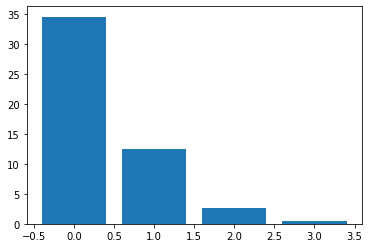

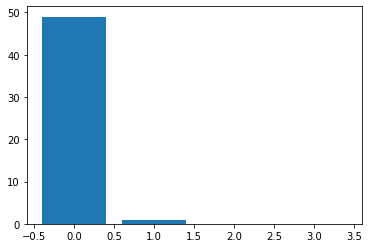

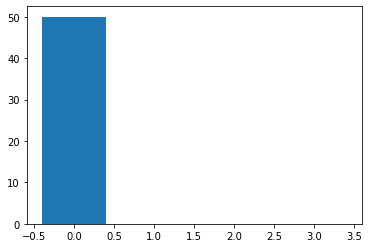

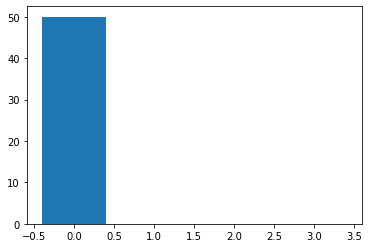

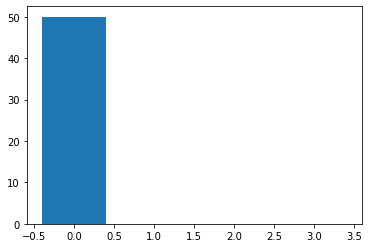

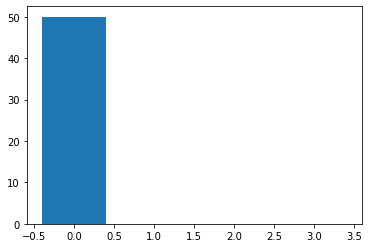

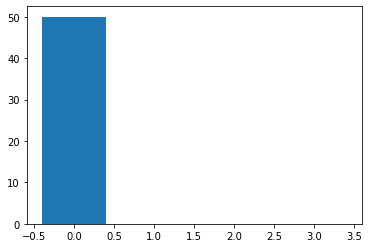

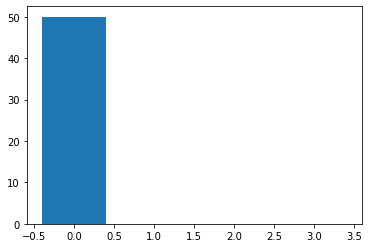

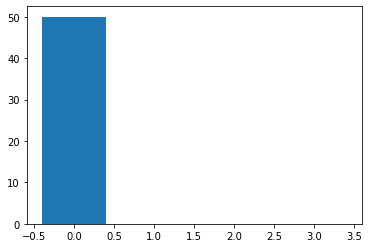

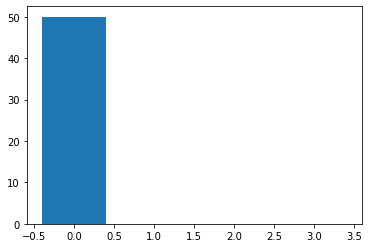

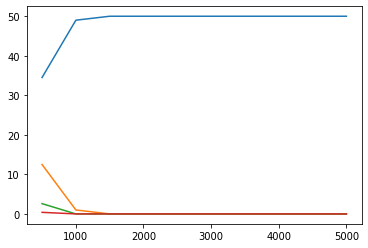

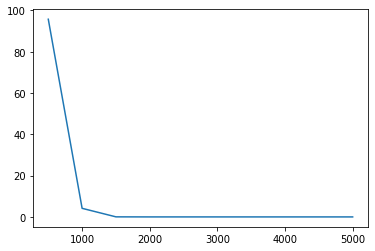

In [9]:
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO) 
tf.autograph.set_verbosity(0, False)

generator_lr = 0.001
discriminator_lr = 0.0002

# Configure the GAN estimator with all the functions from above
gan_estimator = tfg.estimator.GANEstimator(
    generator_fn=quantum_generator_model,
    discriminator_fn=discriminator_model,
    generator_loss_fn=tfg.losses.modified_generator_loss,
    discriminator_loss_fn=tfg.losses.modified_discriminator_loss,
    generator_optimizer=tf.compat.v1.train.AdamOptimizer(generator_lr),
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(discriminator_lr),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)


steps_per_eval =  500#@param
max_train_steps =  5000#@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
frequencies = []
entropy = []

cur_step = 0
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)
  gan_estimator.train(generate_data, max_steps=next_step)
  steps_taken = next_step - cur_step
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(generate_data, 
                                   steps=batches_for_eval_metrics)
  
  # Generate predictions
  iterator = gan_estimator.predict(generate_data)
  predictions = np.array([next(iterator) for _ in range(10)])
  frequency = np.mean(
      [np.bincount(p.astype(int), minlength=4) for p in predictions], axis=0)
  print(frequency)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  plt.figure()
  plt.bar(np.arange(0,4), frequency)
  frequencies.append(frequency)
  entropy.append(metrics['entropy'])

plt.figure()
plt.plot(steps, frequencies)
plt.figure()
plt.plot(steps, entropy)